# MNIST CNN solution using a multiprocess procedure on GPU units
Definitions section and data download

In [502]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torchsummary import summary
from torchvision import datasets, transforms
import time
import numpy as np
import pandas as pd
import math

Hyperparameters definitions:

In [169]:
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

Downloading the data set, then images are packed in blocks (or batches) based on the parameter defined above in order to reduce the computation load.

In [170]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=trans, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=trans, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print('Images for training: {}, images for testing: {}'.format(len(train_dataset), len(test_dataset)))

Images for training: 60000, images for testing: 10000


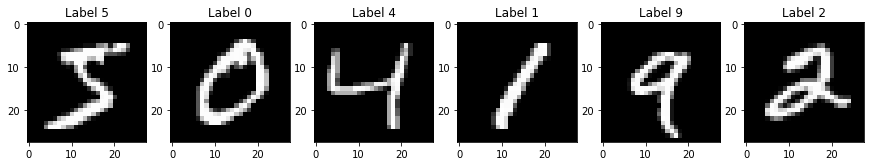

In [171]:
# Figures display example
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1, 6, i+1)
    sample_image, sample_target = train_dataset[i]
    sample_image = torch.squeeze(sample_image).numpy()
    plt.imshow(sample_image, cmap='gray')
    plt.title('Label {}'.format(sample_target.item()))

## CNN model and optimization definition:

In [301]:
class ConvNet(nn.Module):
    def __init__(self, parallel = False):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
#             nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
#             nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        if parallel:
            self.layer1 = nn.DataParallel(self.layer1)
            self.layer2 = nn.DataParallel(self.layer2)
    
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
    # Function to print out the intermediate values for an input image
    def return_steps(self, x):
        cnv1 = self.layer1(x)
        cnv2 = self.layer2(cnv1)
        cnv3 = cnv2.reshape(cnv2.size(0), -1)
        lfc1 = self.fc1(cnv3)
        lfc2 = self.fc2(lfc1)
        lfc3 = self.fc3(lfc2)
        return cnv1, cnv2, cnv3, lfc1, lfc2, lfc3
        

model = ConvNet(parallel=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    model.cuda()
    
# Loss and optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [264]:
summary(model, (1, 28, 28), 1, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 6, 24, 24]             156
            Conv2d-2             [1, 6, 24, 24]             156
         MaxPool2d-3             [1, 6, 12, 12]               0
         MaxPool2d-4             [1, 6, 12, 12]               0
      DataParallel-5             [1, 6, 12, 12]               0
            Conv2d-6              [1, 16, 8, 8]           2,416
            Conv2d-7              [1, 16, 8, 8]           2,416
         MaxPool2d-8              [1, 16, 4, 4]               0
         MaxPool2d-9              [1, 16, 4, 4]               0
     DataParallel-10              [1, 16, 4, 4]               0
          Dropout-11                   [1, 256]               0
           Linear-12                   [1, 120]          30,840
           Linear-13                   [1, 100]          12,100
           Linear-14                   

## Training the model and test validation:

In [247]:
time_start = time.time()
# Training the model
total_step, loss_list, acc_list = len(train_loader), [], []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Run the forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking the accuracy
        total = float(labels.size(0))
        _, predicted = torch.max(outputs.data, 1)
        correct = torch.sum(predicted == labels).item()
        acc_list.append(correct / total)

        if (i + 1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

# time_end = datetime.datetime.now()
# time_delta = time_end - time_start
print('Training time (in seconds): {:.2f}'.format(time.time() - time_start))

Epoch [1/5], Step [200/600], Loss: 0.3087, Accuracy: 89.00%
Epoch [1/5], Step [400/600], Loss: 0.2965, Accuracy: 88.00%
Epoch [1/5], Step [600/600], Loss: 0.4243, Accuracy: 92.00%
Epoch [2/5], Step [200/600], Loss: 0.1295, Accuracy: 97.00%
Epoch [2/5], Step [400/600], Loss: 0.2194, Accuracy: 95.00%
Epoch [2/5], Step [600/600], Loss: 0.3664, Accuracy: 97.00%
Epoch [3/5], Step [200/600], Loss: 0.1399, Accuracy: 95.00%
Epoch [3/5], Step [400/600], Loss: 0.1447, Accuracy: 96.00%
Epoch [3/5], Step [600/600], Loss: 0.3325, Accuracy: 96.00%
Epoch [4/5], Step [200/600], Loss: 0.1344, Accuracy: 97.00%
Epoch [4/5], Step [400/600], Loss: 0.1208, Accuracy: 97.00%
Epoch [4/5], Step [600/600], Loss: 0.3148, Accuracy: 93.00%
Epoch [5/5], Step [200/600], Loss: 0.0568, Accuracy: 97.00%
Epoch [5/5], Step [400/600], Loss: 0.1357, Accuracy: 96.00%
Epoch [5/5], Step [600/600], Loss: 0.2585, Accuracy: 98.00%
Training time (in seconds): 38.32


Text(0.5,1,'Accuracy')

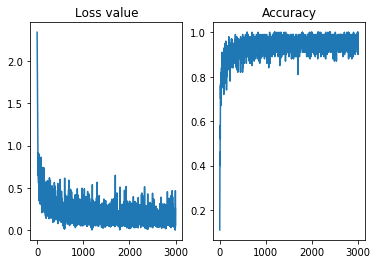

In [492]:
f, axarr = plt.subplots(1, 2)
axarr[0].plot(loss_list)
axarr[0].set_title('Loss value')
axarr[1].plot(acc_list)
axarr[1].set_title('Accuracy')

In [249]:
# Testing the model
prediction_errors = {}
model.eval()
with torch.no_grad():
    correct = 0
    total = float(0)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Selecting some errors to display
        error = (predicted != labels)
        for i in range(error.sum()):
#             if len(prediction_errors) < 6:
            prediction_errors[len(prediction_errors)] = {'image': images[error][i].cpu().numpy(), 'label': labels[error][i].item(), 'predicted': predicted[error][i].item()}
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 10000 test images: 97.74 %


## Some errors prediction examples using the test set:

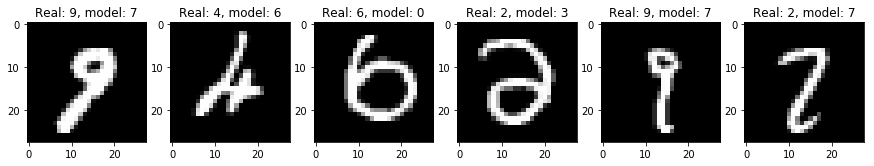

In [250]:
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1, 6, i+1)
    sample_image = (prediction_errors[i]['image']).reshape(28, 28)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Real: {}, model: {}'.format(prediction_errors[i]['label'], prediction_errors[i]['predicted']))

## Weights representation for the last full connected layer (output):

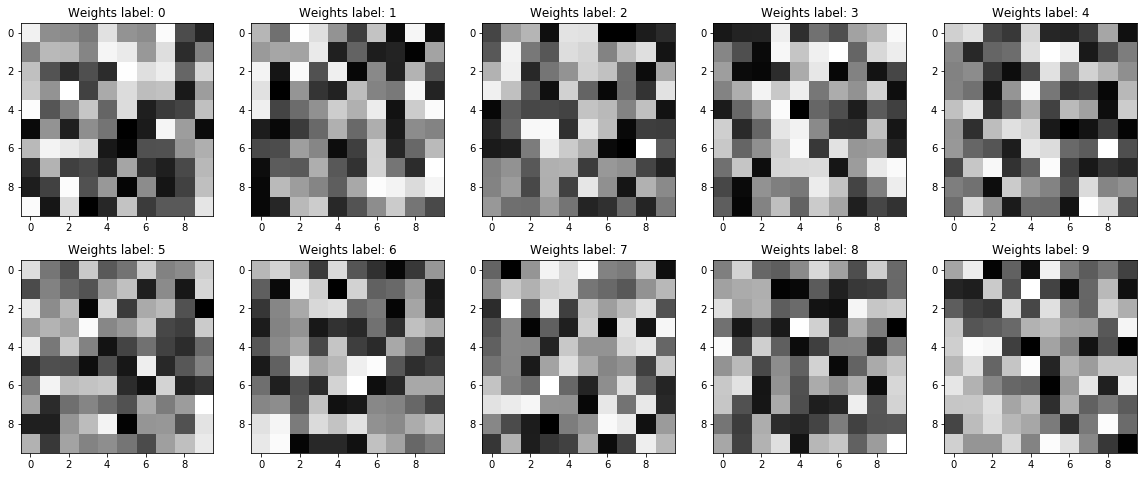

In [300]:
fig = plt.figure(figsize=(20, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sample_image = model.fc3.weight[i, :].view(10, 10).detach().cpu().numpy()
    plt.imshow(sample_image, cmap='gray')
    plt.title('Weights label: {}'.format(i))

## Training load - one GPU, time: 38.38 seconds

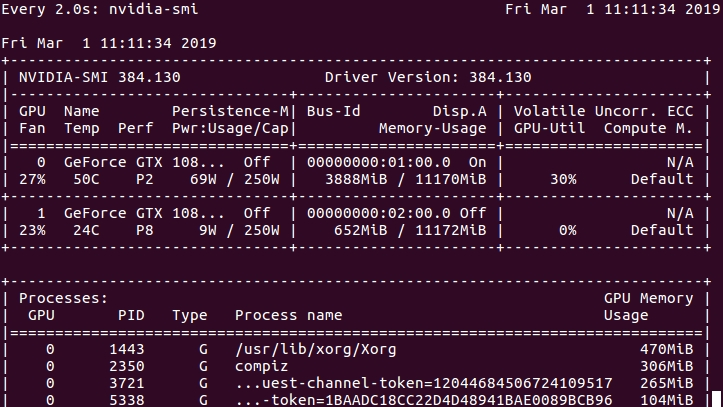

## Training load - Multi GPU, time: 41.45 seconds

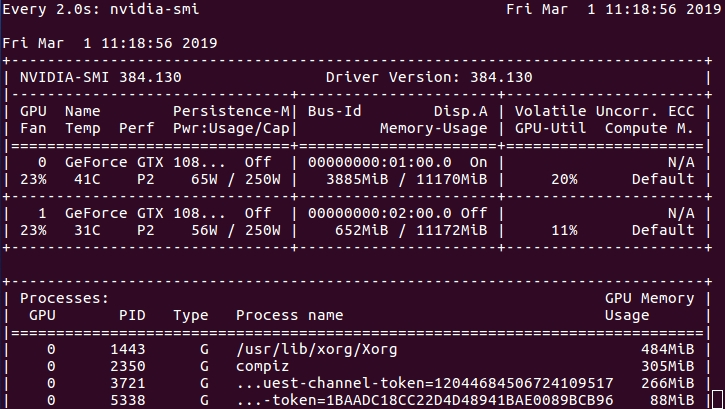

## Kernel weights for convolution layer 1:

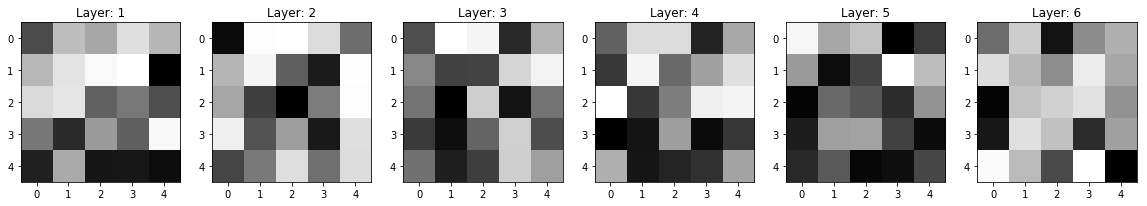

In [299]:
fig = plt.figure(figsize=(20, 11))
for param in model.parameters():
    param = param.view(-1, 5, 5)
    for j in range(len(param)):
        plt.subplot(1, 6, j+1)
        img = param.data[j].cpu().numpy()
        plt.imshow(img, cmap='gray')
        plt.title('Layer: {}'.format(j+1))
    break

## Kernel weights for convolution layer 2:

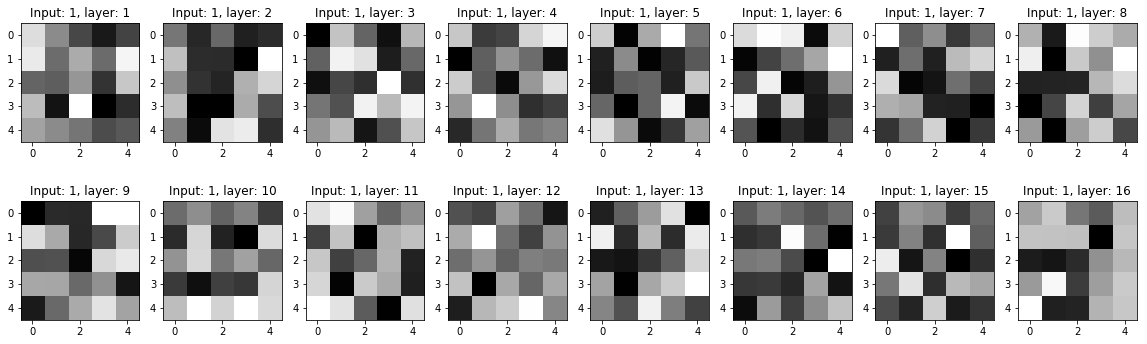

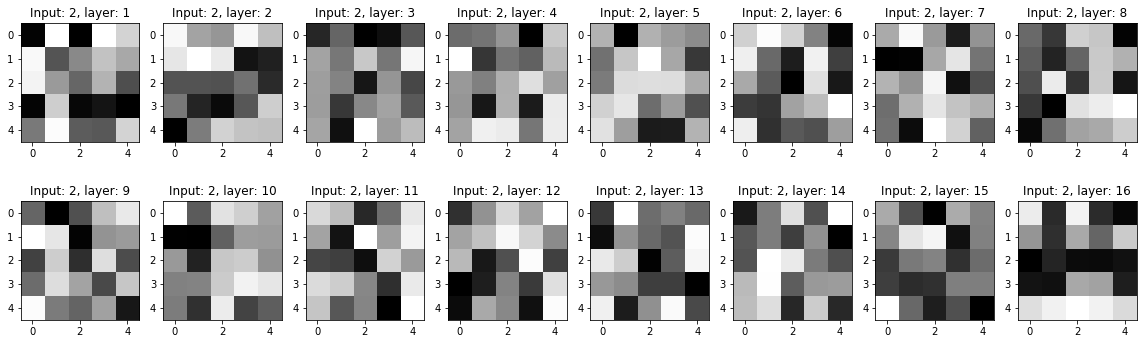

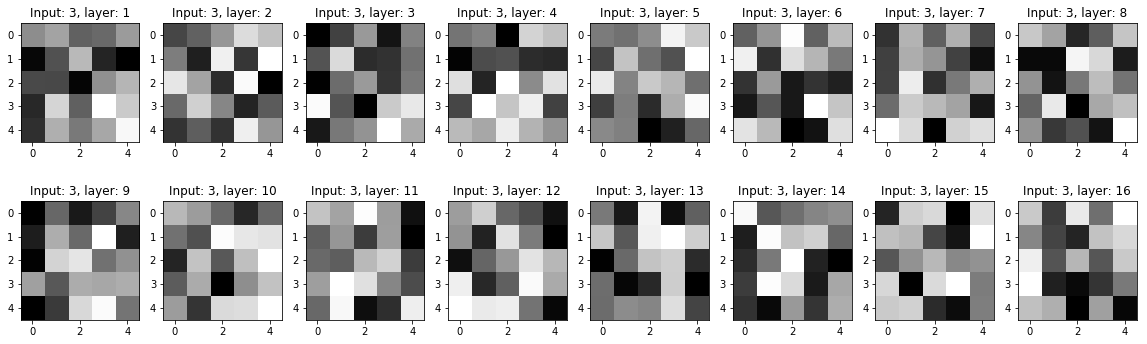

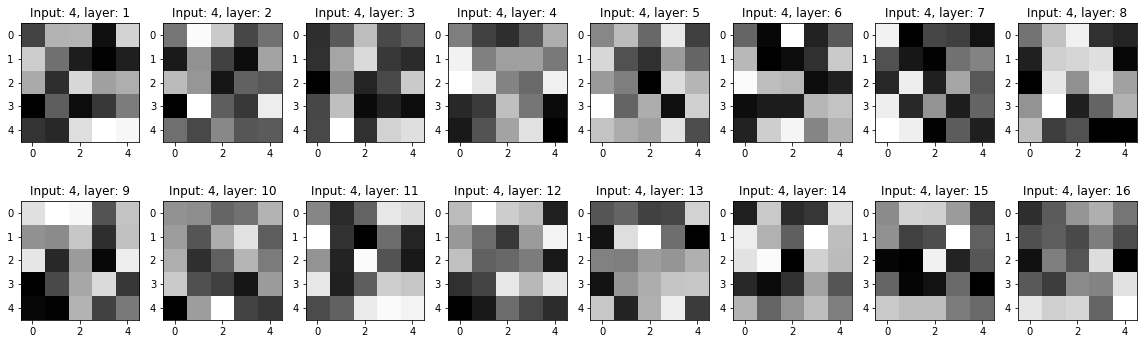

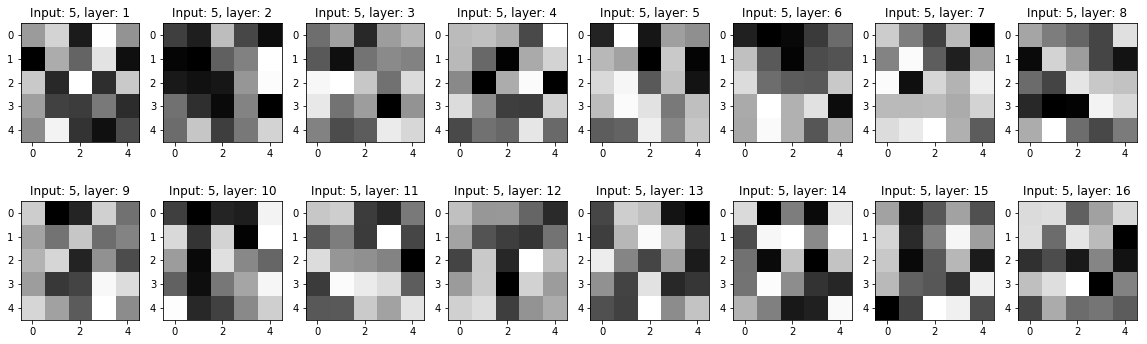

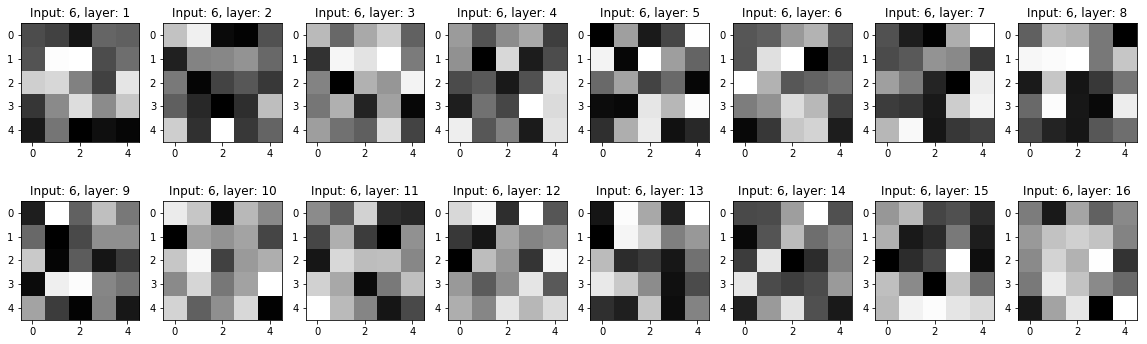

In [298]:
i = 0
for param in model.parameters():
    i += 1
    if i == 3:
        for j in range(6):
            param_tmp = param[:, j, :, :]
            fig = plt.figure(figsize=(20, 6))
            for k in range(len(param_tmp)):
                plt.subplot(2, 8, k+1)
                img = param_tmp.data[k].cpu().numpy()
                plt.imshow(img, cmap='gray')
                plt.title('Input: {}, layer: {}'.format(j+1, k+1))

## Activation layer values, label value: 7

Text(0.5,1,'Label image: 7')

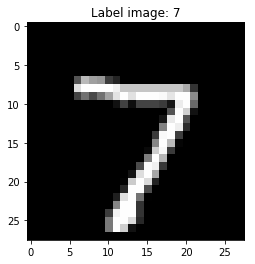

In [287]:
sample_image, sample_target = torch.reshape(test_dataset[0][0], [1, 1, 28, 28]), test_dataset[0][1].item()
out = model.return_steps(sample_image)
plt.imshow(sample_image.cpu().view(28, 28), cmap='gray')
plt.title('Label image: {}'.format(sample_target))

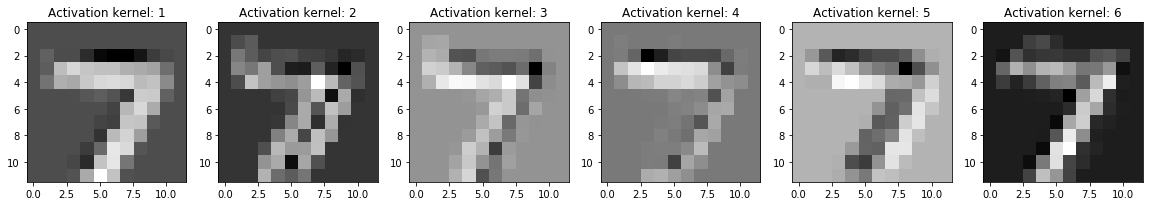

In [293]:
out_tmp = out[0].squeeze()
fig = plt.figure(figsize=(20, 11))
for i in range(out_tmp.size(0)):
    plt.subplot(1, 6, i+1)
    img = out_tmp[i].detach().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.title('Activation kernel: {}'.format(i+1))

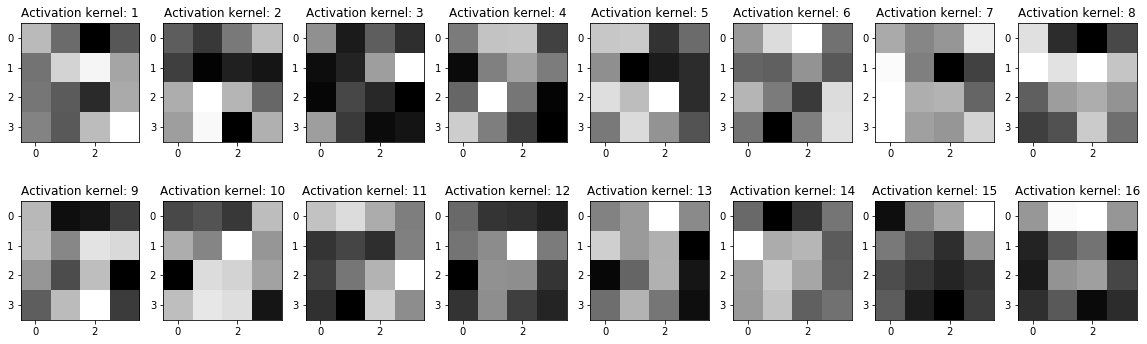

In [317]:
out_tmp = out[1].squeeze()
fig = plt.figure(figsize=(20, 6))
for i in range(out_tmp.size(0)):
    plt.subplot(2, 8, i+1)
    img = out_tmp[i].detach().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.title('Activation kernel: {}'.format(i+1))

## Code to get ten sequences of each label after the second Convulation layer:

In [487]:
num_val = np.zeros(10)
sequences = {}
for j in range(len(train_dataset)):
    if sum(num_val) >= 90:
        break
    out = model.return_steps(torch.reshape(test_dataset[j][0], [1, 1, 28, 28]))
    label = test_dataset[j][1].item()
    lab_col = str(int(num_val[label]))
    if label in sequences:
        df = pd.DataFrame(out[2].detach().t().cpu().numpy(), columns=[lab_col])
        sequences[label][lab_col] = df
    else:
        sequences[label] = pd.DataFrame(out[2].detach().t().cpu().numpy(), columns=[lab_col])
    if num_val[label] < 9:
        num_val[label] += 1

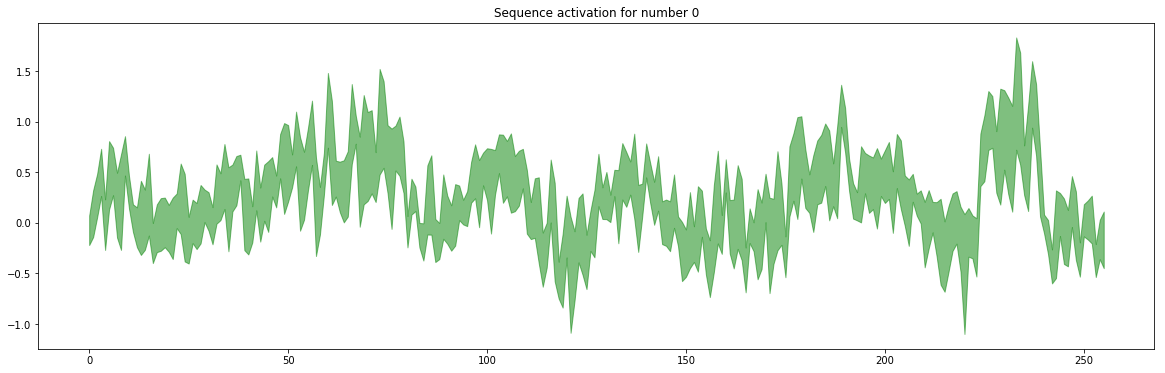

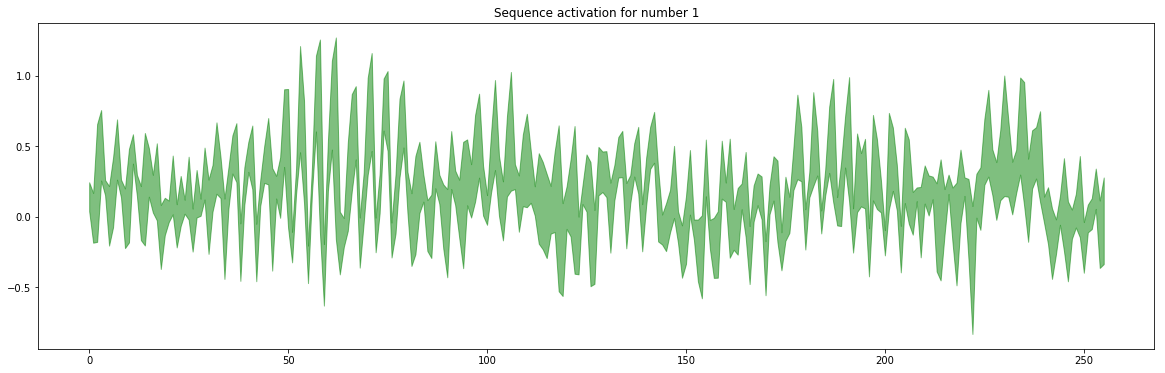

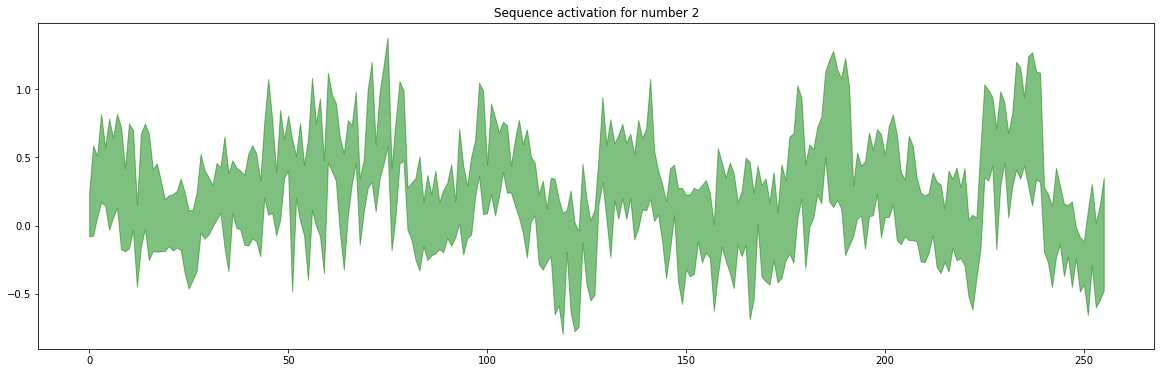

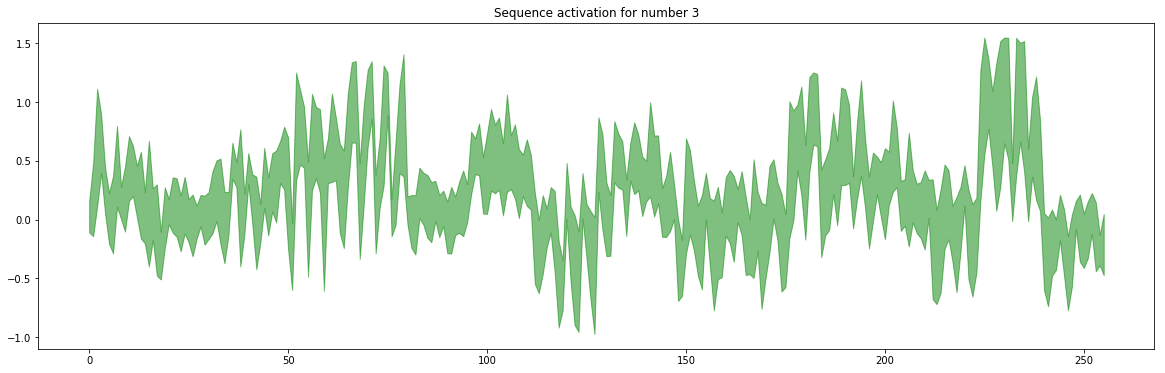

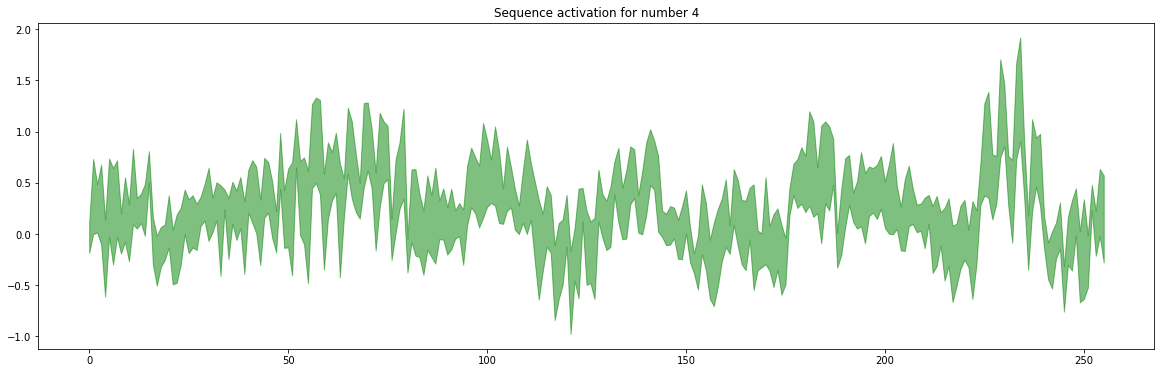

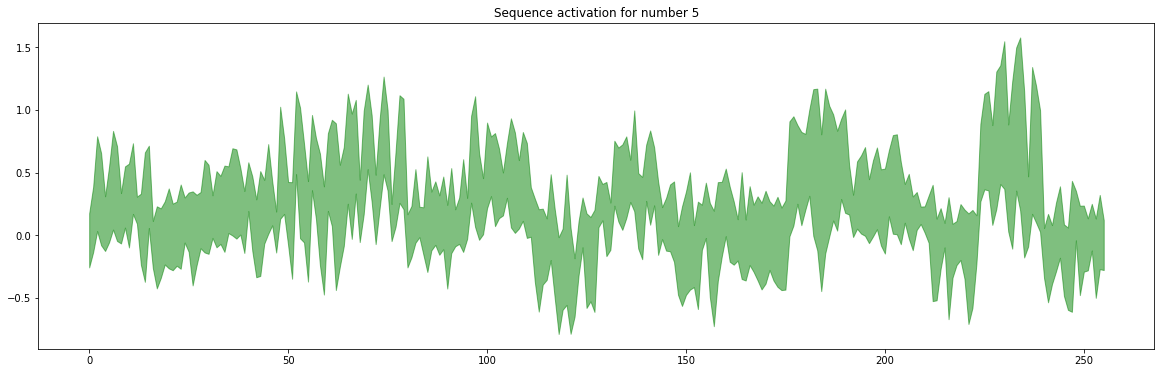

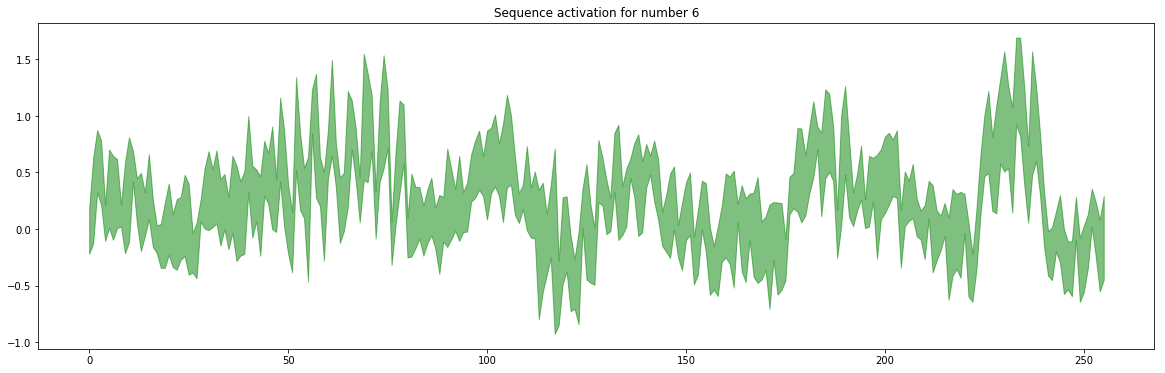

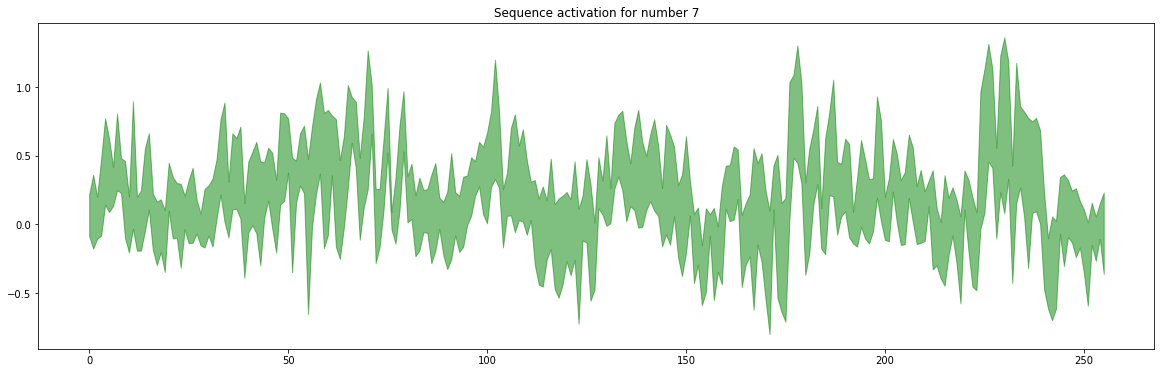

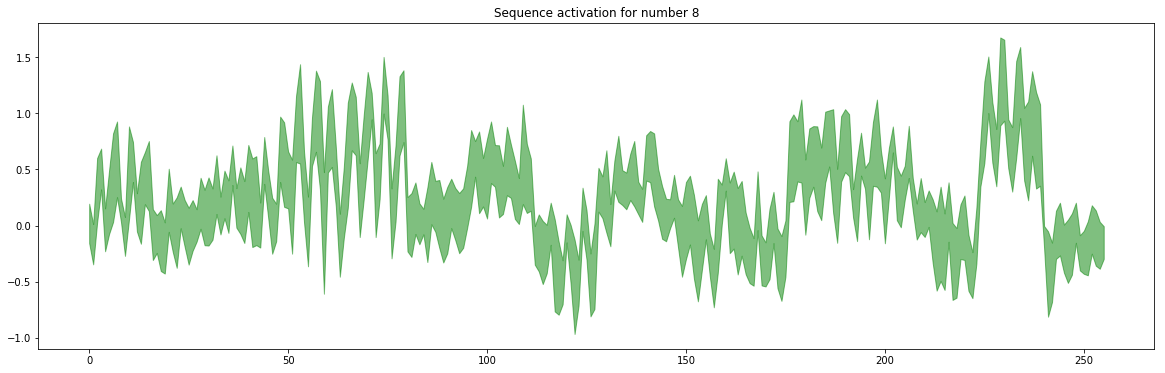

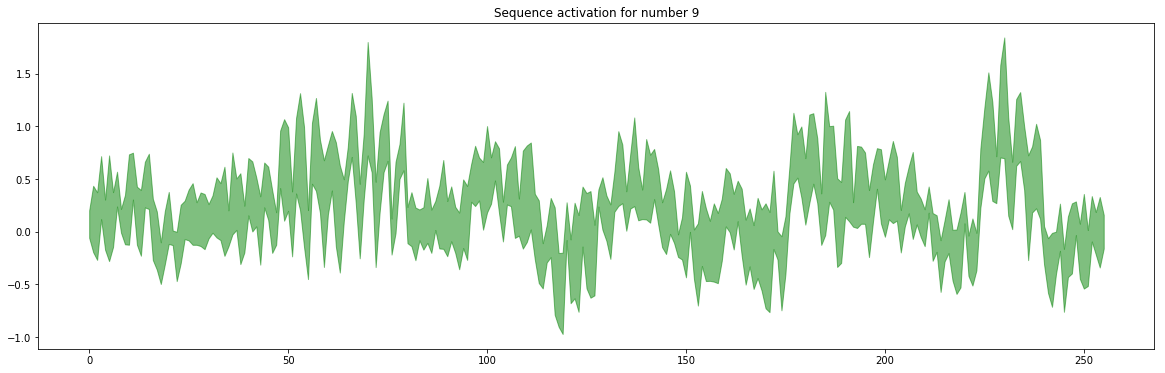

In [488]:
for i in range(10):
    fig = plt.figure(figsize=(20, 6))
    plt.fill_between(np.arange(256), sequences[i].min(1), sequences[i].max(1), color = "green",alpha = 0.5)
    plt.title('Sequence activation for number {}'.format(i))

Text(0.5,1,'Label image: 7')

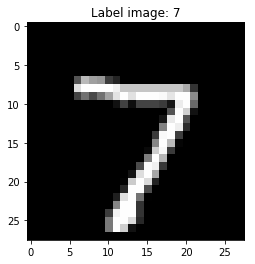

In [494]:
sample_image, sample_target = torch.reshape(test_dataset[0][0], [1, 1, 28, 28]), test_dataset[0][1].item()
out = model.return_steps(sample_image)
plt.imshow(sample_image.cpu().view(28, 28), cmap='gray')
plt.title('Label image: {}'.format(sample_target))

In [510]:
image = sample_image
image.size()

torch.Size([1, 1, 28, 28])

Text(0.5,1,'Label image: 7')

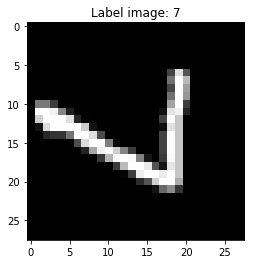

In [536]:
sample_image, sample_target = torch.reshape(test_dataset[0][0], [1, 1, 28, 28]).transpose(2, 3).flip(3), test_dataset[0][1].item()
# sample_image = sample_image.transpose(2, 3).flip(3)
out = model.return_steps(sample_image)
plt.imshow(sample_image.cpu().view(28, 28), cmap='gray')
plt.title('Label image: {}'.format(sample_target))

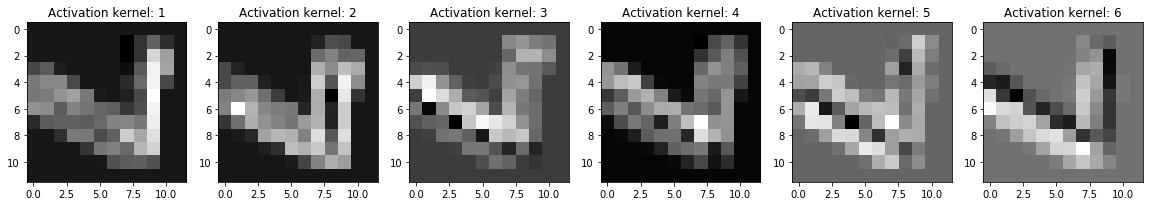

In [537]:
out_tmp = out[0].squeeze()
fig = plt.figure(figsize=(20, 11))
for i in range(out_tmp.size(0)):
    plt.subplot(1, 6, i+1)
    img = out_tmp[i].detach().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.title('Activation kernel: {}'.format(i+1))

In [538]:
print('Rotated image is labeled as {} by the network '.format(out[5].max(1)[1].item()))

Rotated image is labeled as 6 by the network 


Text(0.5,1,'Sequence activation for number 7. In red, the sequence generated by the convolution of the rotated image')

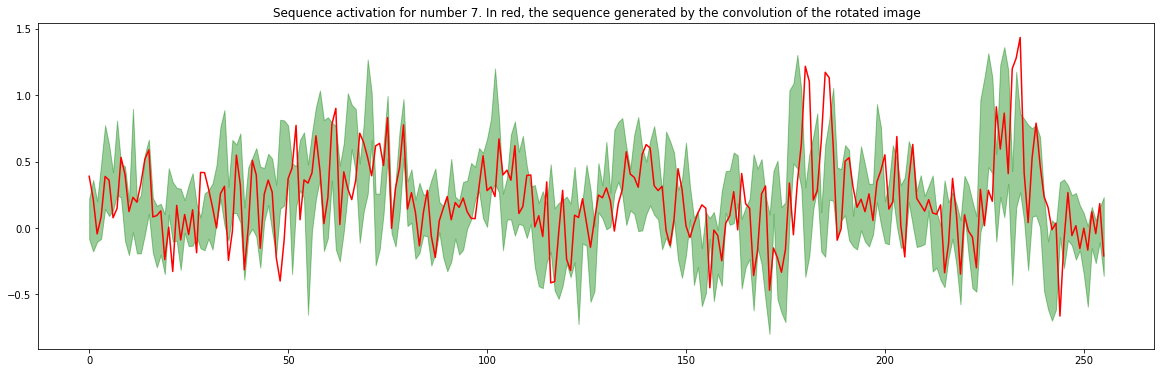

In [541]:
fig = plt.figure(figsize=(20, 6))
plt.fill_between(np.arange(256), sequences[7].min(1), sequences[7].max(1), color = "green",alpha = 0.4)
plt.plot(np.arange(256), out[2].detach().t().cpu().numpy(), color='red')
plt.title('Sequence activation for number {}. In red, the sequence generated by the convolution of the rotated image'.format(7))

Text(0.5,1,'Sequence activation for number 6. In red, the sequence generated by the convolution of the rotated image')

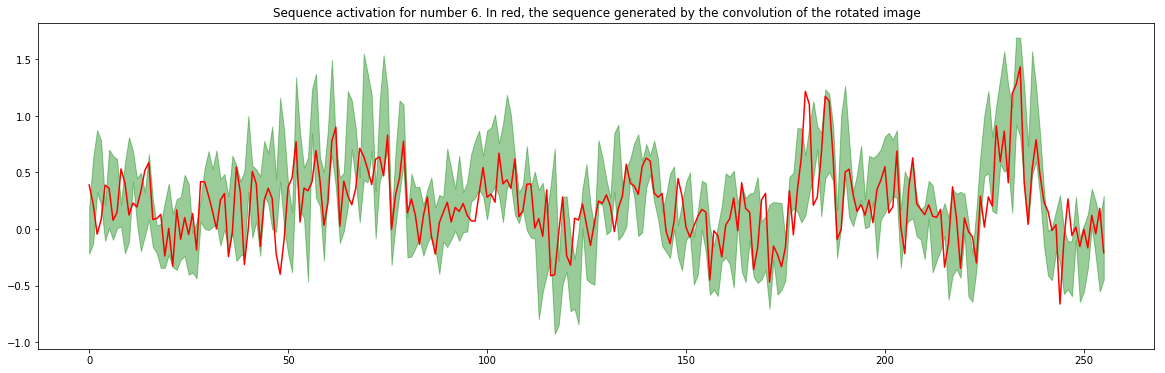

In [542]:
fig = plt.figure(figsize=(20, 6))
plt.fill_between(np.arange(256), sequences[6].min(1), sequences[6].max(1), color = "green",alpha = 0.4)
plt.plot(np.arange(256), out[2].detach().t().cpu().numpy(), color='red')
plt.title('Sequence activation for number {}. In red, the sequence generated by the convolution of the rotated image'.format(6))